# Ensemble Learning and Random Forests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Voting Method

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators = [
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))])

In [3]:
for name, clf in voting_clf.named_estimators.items():
    clf.fit(X_train, y_train)
    print(f"{name}: {clf.score(X_test, y_test)}")

lr: 0.864
rf: 0.896
svc: 0.896


In [4]:
# When call the predict method -> it performs hard voting -> output 1 because 2/3 of the classifiers predict 1
print(voting_clf.predict(X_test[:1]))
np.array([clf.predict(X_test[:1]) for clf in voting_clf.estimators_]).reshape(1, 3)

[1]


array([[1, 1, 0]], dtype=int64)

In [5]:
# achieve better accuracy than the best classifier in the ensemble
voting_clf.score(X_test, y_test)

0.912

Soft voting is averaged over all the individual classifiers probability predictions (If all the classifiers have `predict_proba()` method). It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

All you need to do is set the voting attribute hyperparameter to "soft".

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

A `Bagging Classifiers` automatically `perform soft voting` instead of `hard voting` if the base estimator `can make a probability prediction`, which is in case with decision tree. 

### One tree vs 500 trees bagging

!["1 tree vs bagging 500 trees"](images/1tree_vs_bagging.png)

## Out-of-bag Evaluation

In [8]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ 

0.896

According to the oob_score the bagging classifier can achieve about 89.6% accuracy on the test set.

In [9]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The OOB decision function for each training instance is also available through the `oob_decision_function_` attribute. Since the base classifier has a `predict_proba()` method, the decision function return class probabilities for each training instance.

In [10]:
bag_clf.oob_decision_function_[:3] # probabilities for the first 3 instances 

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

## Random Forest

Random forest is an ensemble of decision trees, generally trained via the bagging method (sometimes pasting), typically with `max_samples` set to the size of training set. `Instead of` building a `BaggingClassifier` and passing it a Decision Tree, you can `use RandomForestClassifier` for `convenience` and `optimization` for `Decision Tree`.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnf_clf.fit(X_train, y_train)
y_pred_rf = rnf_clf.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred_rf)

0.912

The Random Forest has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing tree, instead of searching for the very best feature when splitting a node, it searches for the best feature among random subset of features. By default, it samples $\sqrt{n}$ features ($n$ is the total number of features).


In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_features='sqrt',
                                                   max_leaf_nodes=16),
                  n_estimators=500, n_jobs=-1, random_state=42)

In [14]:
accuracy_score(y_test, bag_clf.predict(X_test))

0.912

## Feature Importance

The random forest make it easy to measure the relative importance of each feature. Scikit-learn measures a features's importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. Can use `feature_importances_` of random forest class.


In [15]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.feature_names):
    print(f"{name}: {round(score, 2)}")


sepal length (cm): 0.11
sepal width (cm): 0.02
petal length (cm): 0.44
petal width (cm): 0.42


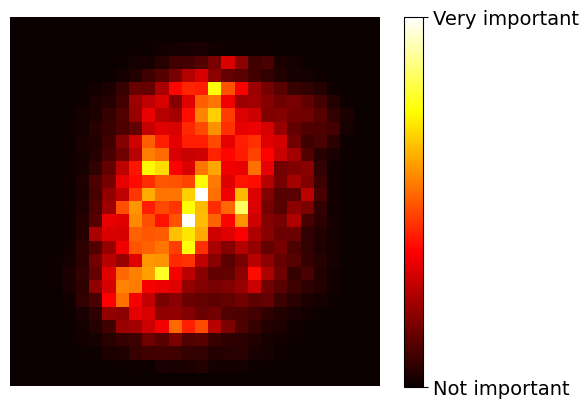

In [16]:
# draw heat map of feature importances of mnist dataset
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml("mnist_784", return_X_y=True, as_frame=False, parser="auto")

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

## Boosting

### AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42, algorithm="SAMME"
)
ada_clf.fit(X_train, y_train)
accuracy_score(y_test, ada_clf.predict(X_test))

0.88

If the AdaBoost is overfitting the training set, you can try reducing the number of estimator or more strongly regularizing the base estimator.

## Gradient Boosting

Let’s generate a noisy quadratic dataset and fit a `DecisionTreeRegressor` to it:

In [18]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - .5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x^2 + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we train a second Decision tree on the residual error made by first predictor.

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then, we will train the third predictor on the residual error made by second predictor. 

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [21]:
# let make prediction on a new instance
X_new = np.array([[-0.4], [0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

We can use Scikit-Learn GradientBoostingRegressor class to train GBRT ensembles more easily.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Much `like the RandomForest`, GBR has` hyperparameter to control the growth of decision trees`, as well as the `hyperparameter to control the ensemble training`.

The `learning rate hyperparameter` `scales the contribution of each tree`. If you set it to a `low value`, such as 0.5, you` will need more trees` in the ensemble to fit the training set, but the predictions will usually generalize better. This is a `regularization technique called shrinkage.` In the figure below, `on the left, the GBRT does not have enough trees to fit` the training set, while the one `on the right has very much trees`. If we add `more trees, the GBRT will overfitting.`

![learning rate](images/learning_rate_gbrt.png)

`Instead of use GridSearchCV, RandomizedSearchCV` to `find` the optimal `number of trees`, we can use the `n_iter_no_change` hyperparameter. The GBRT will `automatically stop` adding more trees during training `if it sees that the last 10 trees didn't help`. This work likely to `early stopping. `

In [25]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, n_estimators=500,
    n_iter_no_change=10, random_state=42, learning_rate=0.05
)

gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [26]:
gbrt_best.n_estimators_

92

When the `n_iter_no_change` is set, the fit() method automatically splits the training into a smaller training set and a validation set, this allows it to evaluate the model's performance each time it adds a new tree. The size of the validation set is controlled by validation_fraction hyperparameter, which is 10% by default.

The GIRT class also supports a `subsample` hyperparameter, which `specifies the fraction of training instances` to be `used for training each tree`. For example, if it equal to 0.25, then each tree is trained on 25% of the training instances, selected randomly. This is called `stochastic gradient boosting.`